In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [2]:
pth_in = os.path.join('..', 'data')
pth_data = os.path.join(pth_in, 'modeling', 'interpret')
pth_feat = os.path.join(pth_in, 'features', 'biomart')
pth_out = os.path.join('..', 'figures')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_data, 'training.h5ad'))
adata

AnnData object with n_obs × n_vars = 1575028 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 'training', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score'

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
get_name = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_name(fn) : fn for fn in feat_fn if 'union' not in fn}
for key in feat_dict:
    feat_dict[key] = pd.read_csv(feat_dict[key])
    print(key, feat_dict[key])

EMTHallmark     hsapiens mmusculus
0      POSTN     Postn
1       SGCG      Sgcg
2     PMEPA1    Pmepa1
3       CDH2      Cdh2
4       MSX1      Msx1
..       ...       ...
199     FMOD      Fmod
200  COL11A1   Col11a1
201     RGS4      Rgs4
202      JUN       Jun
203    VCAM1     Vcam1

[204 rows x 2 columns]
GSE136689    mmusculus hsapiens
0      Map1b    MAP1B
1       Irx1     IRX1
2        Id2      ID2
3     Homer2   HOMER2
4        Clu      CLU
..       ...      ...
67     Aldoa    ALDOA
68       Mmd      MMD
69      Peg3     PEG3
70   Slc16a3  SLC16A3
71    Mpped2   MPPED2

[72 rows x 2 columns]
GSE162534     mmusculus  hsapiens
0        Cdh2      CDH2
1       Greb1     GREB1
2        Sqle      SQLE
3    Tnfrsf19  TNFRSF19
4       Rspo3     RSPO3
..        ...       ...
201      Cst3      CST3
202    Mogat2    MOGAT2
203  Serpinh1  SERPINH1
204       Sp5       SP5
205      Peg3      PEG3

[206 rows x 2 columns]
GSE201257     mmusculus hsapiens
0     Phactr1  PHACTR1
1       Vcam1

In [5]:
# integrated_gradients vs. latent_z (correlation)
def get_pearsonr(X: csr_matrix,
                 y: np.ndarray,
                 ix: pd.Index) -> pd.Series:
    n = y.size
    s_y, mu_y = y.std(ddof = 1), y.mean()
    sum_x  = np.asarray(X.sum(0)).ravel()
    sum_x2 = np.asarray(X.multiply(X).sum(0)).ravel()
    dot = y @ X
    mu_x = sum_x / n
    s_x = np.sqrt((sum_x2 - n * mu_x ** 2) / (n - 1))
    cov = (dot - n * mu_x * mu_y) / (n - 1)
    corr = cov / (s_x * s_y)
    corr[s_x == 0] = np.nan
    corr = pd.Series(corr, index = ix)
    return corr.sort_values(key = abs, ascending = False)

ig = adata.layers['integrated_gradients']
z = adata.obs.latent_z.values
ix = adata.var_names
corr = get_pearsonr(ig, z, ix); corr

Marcks     0.820915
Eef1g      0.806805
Rps20      0.805982
Gabarap    0.799973
Ncl        0.785884
             ...   
Dlx5       0.001846
Sntb1     -0.001808
Hbb-y      0.000821
Hmga1     -0.000548
Gadd45a    0.000379
Length: 856, dtype: float64

In [ ]:
# top features
n = 200; top_feats = corr.head(n).index
summary_df = pd.read_csv(os.path.join(pth_in, 'summary.csv'), index_col = 0)
vals = {key : df.mmusculus.isin(top_feats).sum() for key, df in feat_dict.items()}
vals = pd.Series(vals); vals.index = vals.index.map(summary_df.Name.to_dict())
vals.sort_values(ascending = False, inplace = True); vals

Embryonic Hindlimb            57
Cranial Neural Crest          52
Primitive Streak              50
Neuromesodermal Progenitor    42
EMT Hallmark                  34
Schwann Cell Precursor        17
Splanchnic Mesoderm           15
dtype: int64

/tmp/ipykernel_3367014/498012900.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), size = 7)
/tmp/ipykernel_3367014/498012900.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticklabels(), size = 7)


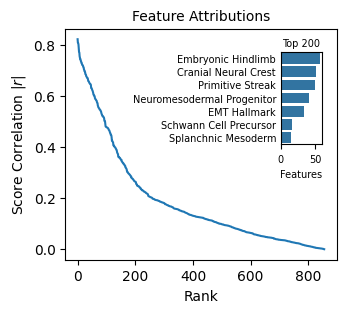

In [8]:
# plot score/attribution correlations
fig, ax = plt.subplots(1, 1, figsize = (3.5, 3))
ax.plot(corr.abs().values)
ax.set_xlabel('Rank')
ax.set_ylabel(r'Score Correlation $|r|$')
ax.set_title('Feature Attributions', size = 10)

# inset: top features
ax1 = ax.inset_axes([.795, .5, .15, .4])
sns.barplot(vals, ax = ax1, orient = 'h')
ax1.set_title(f'Top {n}', size = 7, pad = 4)
ax1.set_xlabel('Features', size = 7)
ax1.set_xticklabels(ax1.get_xticklabels(), size = 7)
ax1.set_yticklabels(ax1.get_yticklabels(), size = 7)
ax1.tick_params('y', size = 0)

fn = os.path.join(pth_out, 'attributions.svg')
plt.savefig(fn, bbox_inches = 'tight')